# T-SNE & U-Map Interactive

In [6]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import umap.plot
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from ketos.data_handling.data_feeding import JointBatchGen
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
import ketos.data_handling.database_interface as dbi

C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)
C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
def feature_extractor(pre_trained_model):
    extractor = tf.keras.models.Sequential(pre_trained_model.model.layers[0:4])
    extractor.trainable = False
    return extractor

In [25]:
thresholds = [0.3]
step_size = 1.0
batch_size = 16
buffer = 0.5
main_folder = r'E:\baseline-with-normalization-reduce-tonal'
#db_name = main_folder + '\\' + 'final-baseline-db-normalized-rtn.h5'
#db_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\ulu2023-db.h5'
db_name = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\pp-all.h5'
temp_folder = main_folder + '\\' + 'temp'
output_dir = r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble'
model_folder = r'E:\baseline-with-normalization-reduce-tonal\models'
#models = [model_folder + '\\' + 'rs-model-0.kt', model_folder + '\\' + 'rs-model-1.kt', model_folder + '\\' + 'rs-model-2.kt', 
#          model_folder + '\\' + 'rs-model-3.kt', model_folder + '\\' + 'rs-model-4.kt', model_folder + '\\' + 'rs-model-5.kt', 
#          model_folder + '\\' + 'rs-model-6.kt', model_folder + '\\' + 'rs-model-7.kt', model_folder + '\\' + 'rs-model-8.kt',
#          model_folder + '\\' + 'rs-model-9.kt']

models = [model_folder + '\\' + 'rs-model-5.kt']

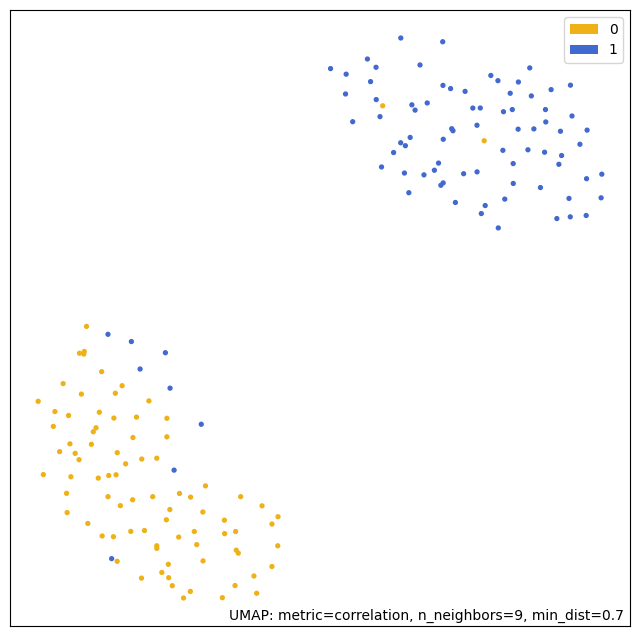

In [26]:
for idx, model_name in enumerate(models):

    db = dbi.open_file(db_name, 'r')
    #table = dbi.open_table(db, '/test')
    table = dbi.open_table(db, '/all')
    classification_csv = "classifications.csv"
    metric_csv = "metrics.csv"
    stats_csv = "stats.csv"
    
    model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)
    gens = []
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    simplified = feature_extractor(model)
    
    scores = []
    labels = []
    output = []
    
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
        # get array for each of size (64,)
        output.extend(simplified(batch_X))

    output_numpy = [x.numpy() for x in output]
    df = pd.DataFrame(output_numpy)

    colours = ['#EFB118', '#4269D0']
    
    mapper = umap.UMAP(n_neighbors=9, min_dist=0.7, metric='correlation', n_components=2).fit(df)
    umap.plot.points(mapper, labels=np.array(labels), color_key_cmap='Paired', color_key=colours, background='white')
    plt.savefig(str(model_name) + '-UMAP.png')
    
    #umap.plot.diagnostic(mapper, diagnostic_type='pca')
    #umap.plot.output_notebook()
    #mapper = umap.UMAP(n_neighbors=9, min_dist=0.7, metric='correlation', n_components=2).fit(df)

    #hover_data = pd.DataFrame({'index':np.arange(len(labels)),
    #                       'label':labels})

    #p = umap.plot.interactive(mapper, labels=labels, hover_data=hover_data, point_size=12, color_key_cmap='Paired', background='white')
    #umap.plot.show(p)

    #umap.plot.connectivity(mapper, show_points=True, edge_bundling='hammer')
    #plt.savefig(str(model_name) + '-UMAP-neuron.png')

   
#    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#    tsne_results = tsne.fit_transform(df)
#    tsne_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'], data=np.column_stack((tsne_results, labels)))
#    grid = sns.FacetGrid(tsne_df, hue="target")
#    grid.map(plt.scatter, 'CP1', 'CP2', alpha=0.2).add_legend()
#    plt.savefig(str(model_name) + '-TSNE.png')
#    plt.show()
    
#    tsne_3d = TSNE(n_components=3, random_state=0)
#    projections = tsne_3d.fit_transform(df)
#    tsne_df3d = pd.DataFrame(columns=['CP1', 'CP2', 'CP3', 'target'], data=np.column_stack((projections, labels)))
    
#    fig = plt.figure(figsize=(6,6))
#    ax = Axes3D(fig, auto_add_to_figure=False)
#    fig.add_axes(ax)
    
#    sc = ax.scatter(tsne_df3d['CP1'], tsne_df3d['CP2'], tsne_df3d['CP3'], s=40, c=tsne_df3d['target'], marker='o', cmap='viridis', alpha=0.5)
#    ax.set_xlabel('CP1')
#    ax.set_ylabel('CP2')
#    ax.set_zlabel('CP3')
    
    # legend
#    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
#    plt.tight_layout()
#    plt.savefig(str(model_name) + '-TSNE-3D.png')
    # save
#    plt.show()

## References
UMAP Site: https://umap-learn.readthedocs.io/en/latest/plotting.html